In [1]:
from collections import Counter

import networkx as nx

import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.misc_utils as misc_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.misc.cpg_const as cpg_const

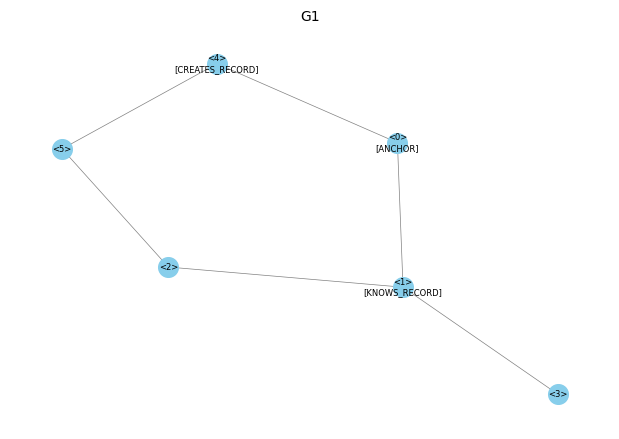

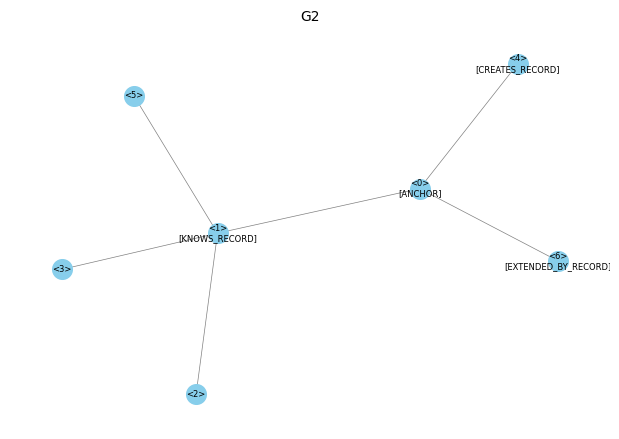

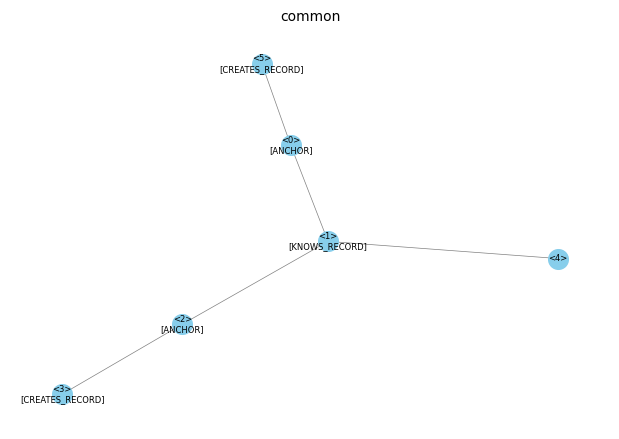

In [2]:
def addCpgNode( G, label: cpg_const.NodeLabel, anchor=False ):
    node_id = G.number_of_nodes()
    anchor_idx = 1 if anchor else 0
    G.add_node( node_id, label=misc_utils.get_enum_idx( label ), anchor=anchor_idx )
    return node_id


# Example usage
G1 = nx.Graph()
n11 = addCpgNode( G1, cpg_const.NodeLabel.RECORD, anchor=True )
n12 = addCpgNode( G1, cpg_const.NodeLabel.KNOWS_RECORD )
n13 = addCpgNode( G1, cpg_const.NodeLabel.RECORD )
n14 = addCpgNode( G1, cpg_const.NodeLabel.RECORD )
n15 = addCpgNode( G1, cpg_const.NodeLabel.CREATES_RECORD )
n16 = addCpgNode( G1, cpg_const.NodeLabel.RECORD )
G1.add_edge( n11, n12 )
G1.add_edge( n12, n13 )
G1.add_edge( n12, n14 )
G1.add_edge( n11, n15 )
G1.add_edge( n15, n16 )
G1.add_edge( n13, n16 )

plot_utils.plot_graph( G1, title="G1", nodeLabels=graph_utils.get_node_labels( G1 ) )

G2 = nx.Graph()
n21 = addCpgNode( G2, cpg_const.NodeLabel.RECORD, anchor=True )
n22 = addCpgNode( G2, cpg_const.NodeLabel.KNOWS_RECORD )
n23 = addCpgNode( G2, cpg_const.NodeLabel.RECORD )
n24 = addCpgNode( G2, cpg_const.NodeLabel.RECORD )
n25 = addCpgNode( G2, cpg_const.NodeLabel.CREATES_RECORD )
n26 = addCpgNode( G2, cpg_const.NodeLabel.RECORD )
n27 = addCpgNode( G2, cpg_const.NodeLabel.EXTENDED_BY_RECORD )
G2.add_edge( n21, n22 )
G2.add_edge( n22, n23 )
G2.add_edge( n22, n24 )
G2.add_edge( n21, n25 )
G2.add_edge( n22, n26 )
G2.add_edge( n21, n27 )
plot_utils.plot_graph( G2, title="G2", nodeLabels=graph_utils.get_node_labels( G2 ) )


def largest_common_subgraph( G1_data, G2_data ):
    G1, anchor1 = G1_data
    G2, anchor2 = G2_data

    def nodes_are_equal( node1, node2 ):
        return (G1.nodes[ node1 ][ "anchor" ] == G2.nodes[ node2 ][ "anchor" ] and
                G1.nodes[ node1 ][ "label" ] == G2.nodes[ node2 ][ "label" ])

    def get_neighbor_label_count( G, node ):
        return dict( Counter( [ G.nodes[ n ][ "label" ] for n in G.neighbors( node ) ] ) )

    def get_min_label_count( a, b ):
        all_labels = set( a.keys() ).union( b.keys() )
        return { key: min( a.get( key, 0 ), b.get( key, 0 ) ) for key in all_labels }

    def add_node( LCS_data, G1_data, G2_data, mapping ):
        LCS, parent = LCS_data
        G1, n1 = G1_data
        G2, n2 = G2_data
        n = LCS.number_of_nodes()  #n = (n1, n2)
        if not nodes_are_equal( n1, n2 ) or n in mapping:
            return
        mapping[ n ] = True
        LCS.add_node( n, label=G1.nodes[ n1 ][ 'label' ], anchor=G1.nodes[ n1 ][ 'anchor' ] )
        if parent is not None:
            LCS.add_edge( parent, n )
        nh1_label_count = get_neighbor_label_count( G1, n1 )
        nh2_label_count = get_neighbor_label_count( G2, n2 )
        nh_label_count = get_min_label_count( nh1_label_count, nh2_label_count )

        for nh1 in G1.neighbors( n1 ):
            for nh2 in G2.neighbors( n2 ):
                if nodes_are_equal( nh1, nh2 ):
                    current_label_count = get_neighbor_label_count( LCS, n )
                    nh_label = G1.nodes[ nh1 ][ 'label' ]
                    if current_label_count.get( nh_label, 0 ) >= nh_label_count.get( nh_label, 0 ):
                        continue
                    add_node( (LCS, n), (G1, nh1), (G2, nh2), mapping )

    LCS = nx.Graph()
    add_node( (LCS, None), (G1, anchor1), (G2, anchor2), { } )
    return LCS


def common_subgraph( graphs ):
    if len( graphs ) == 0:
        return None

    G_common = graphs[ 0 ]
    graphs = [ (G.copy(), graph_utils.get_anchor( G )) for G in graphs[ 1: ] ]

    for G, anchor in graphs:
        anchor_common = graph_utils.get_anchor( G_common )
        G_common = largest_common_subgraph( (G_common, anchor_common), (G, anchor) )

    return G_common


common = common_subgraph( [ G1, G2 ] )
plot_utils.plot_graph( common, title="common", nodeLabels=graph_utils.get_node_labels( common ) )